# Get stationary time series 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import multi_dot, norm
from random import seed
from cnn_graph.lib import models, graph, coarsening
from sklearn.metrics import r2_score, mean_squared_error

Using TensorFlow backend.


In [2]:
# Load data
dist_geo = pd.read_csv("data/distance_paris.csv",header=0,index_col=0)
X_hour = pd.read_csv("data/X_hour_paris.csv",header=0,index_col=0)
T_1, N = X_hour.shape
T_0 = int(T_1*0.9)
T_tv = int(T_0*0.95)

## weekly profile !only use the training set to get the profile!
X_train = X_hour.iloc[:T_tv,].copy()
index = np.tile(np.arange(1,24*7+1), np.int(X_hour.shape[0]/24/7)+1)[:X_hour.shape[0]] - 1
X_train['index'] = index[:T_tv]
wk_pf = X_train.groupby('index').mean()
X_train = X_train.drop(columns = "index")

X_hour, wk_pf = [np.float32(x) for x in [X_hour, wk_pf]]
X_hour_detrend = np.copy(X_hour) - wk_pf[index,:]

## Scale, to make the regularization parameter lambda have the same influence on all var.
X_train = X_hour_detrend[:T_tv,]
sd = X_train.std(axis = 0)
X_hour_detrend_sc = np.multiply(X_hour_detrend, 1/sd)

Text(0.5, 1.0, 'Stationary and scaled')

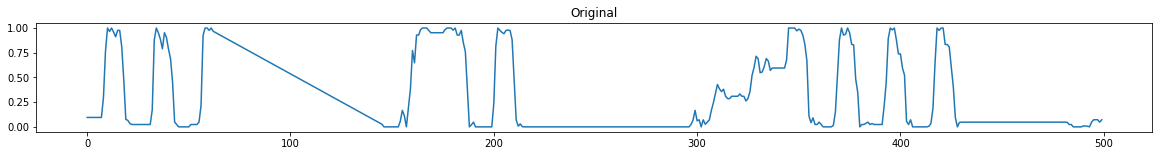

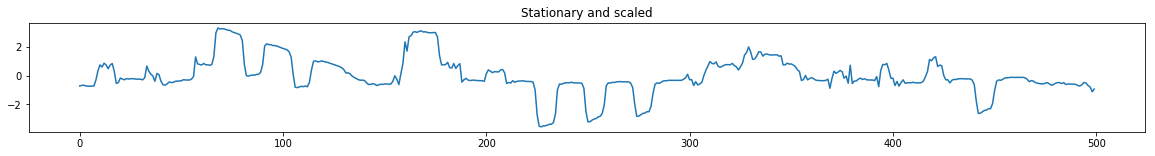

In [3]:
# Stationary and scaled time series
plt.rcParams["figure.figsize"] = (20,2)
plt.figure()
plt.plot(X_hour[:500,5])
plt.title('Original')
plt.figure()
plt.plot(X_hour_detrend_sc[:500,5])
plt.title('Stationary and scaled')

In [4]:
# Sampling size is given
P = int(0.1*N)
print(P)

# Time lag
H = 0

27


## Graph construction
the same as the one used in graph kernel approach

In [5]:
# Build the graph
k = 20 # nb of neighbours
dist, idx = graph.distance_sklearn_metrics(k = k, d = np.array(dist_geo))
A = graph.adjacency(dist, idx, k_self_tuning = 7).astype(np.float32)
graphs, perm = coarsening.coarsen(A, levels=0, self_connections=False) # No pooling used
L = [graph.laplacian(A, normalized=False) for A in graphs]

Layer 0: M_0 = |V| = 274 nodes (0 added),|E| = 3373 edges


## Network architecture

In [6]:
# GCN Architecture.
params = dict()
params['F']              = [16]  # Number of graph convolutional filters.
params['K']              = [50]  # Polynomial orders.
params['p']              = [1]   # Pooling sizes (1 is no pooling).
params['M']              = [128, 500, 64, N]  # Output dimensionality of fully connected layers.

In [7]:
# Selection hyperparameter (dropout rate at the input layer).
params['rate_input']     = P/N   # Rate of an input element being absent

In [10]:
# Training.
params['dir_name']       = 'H0_select'
params['num_epochs']     = 90 # Max epochs. 
params['batch_size']     = 50 
params['learning_rate']  = 0.05

# Time lag.
params['H']              = H    

## Construct selection network

In [11]:
model = models.cgcnn(L, **params, selecting_mode = True, selecting_method = 'dropout')

NN architecture
  input: L_0 = 274
  layer 1: cgconv1
    representation: L_0 * F_1 / p_1 = 274 * 16 / 1 = 4384
    weights: F_0 * F_1 * K_1 = 1 * 16 * 50 = 800
    biases: L_1 * F_1 = 274 * 16 = 4384
  layer 2: fc1
    representation: L_2 = 128
    weights: L_1 * L_2 = 4384 * 128 = 561152
    biases: L_2 = 128
  layer 3: fc2
    representation: L_3 = 500
    weights: L_2 * L_3 = 128 * 500 = 64000
    biases: L_3 = 500
  layer 4: fc3
    representation: L_4 = 64
    weights: L_3 * L_4 = 500 * 64 = 32000
    biases: L_4 = 64
  layer 5: output
    representation: L_5 = 274
    weights: L_4 * L_5 = 64 * 274 = 17536
    biases: L_5 = 274
  Total number of trainable parameters: 681112
Gradient descent optimizer is being used in current selecting mode.


# Training selection network

In [12]:
# Input: All values of all sensors
X_train_H = np.empty((T_tv-H,     N, H+1))
X_val_H   = np.empty((T_0-T_tv-H, N, H+1))
for i in range(H+1):
    X_train_H[:,:,H-i] = X_hour_detrend_sc[(H-i):(T_tv-i),:]
    X_val_H[:,:,H-i]   = X_hour_detrend_sc[(T_tv+H-i):(T_0-i),:]

In [ ]:
losses_train, losses_val, _, _ = model.fit(train_data = X_train_H, train_targets = X_train_H[:,:,H], val_data = X_val_H, val_targets = X_val_H[:,:,H])

In [ ]:
# training convergence check
plt.rcParams["figure.figsize"] = (6,4)
plt.ion()
fig = plt.figure()
plt.plot([x/losses_train[0] for x in losses_train], label = "train")
plt.plot([x/losses_val[0] for x in losses_val], label = "validation")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

## Reproduce the numerical results
Instead of the codes above for new training process, we can reproduce the numerical results reported in the paper. The four trained selection networks are saved in the folder **paris_H0_select_run1**, **paris_H0_select_run2**, **paris_H5_select_run1** and **paris_H5_select_run1**. To access the results, we need to first change the *dir_name* and *H* together with the data to input and output, second, reinitialize the model, then use model.evaluate directly on the data.

In [13]:
H = 0
params['dir_name']       = 'paris_H0_select_run2'
params['H']              = H

X_train_H = np.empty((T_tv-H,     N, H+1))
X_val_H   = np.empty((T_0-T_tv-H, N, H+1))
for i in range(H+1):
    X_train_H[:,:,H-i] = X_hour_detrend_sc[(H-i):(T_tv-i),:]
    X_val_H[:,:,H-i]   = X_hour_detrend_sc[(T_tv+H-i):(T_0-i),:]
    
model = models.cgcnn(L, **params, selecting_mode = True, selecting_method = 'dropout')

NN architecture
  input: L_0 = 274
  layer 1: cgconv1
    representation: L_0 * F_1 / p_1 = 274 * 16 / 1 = 4384
    weights: F_0 * F_1 * K_1 = 1 * 16 * 50 = 800
    biases: L_1 * F_1 = 274 * 16 = 4384
  layer 2: fc1
    representation: L_2 = 128
    weights: L_1 * L_2 = 4384 * 128 = 561152
    biases: L_2 = 128
  layer 3: fc2
    representation: L_3 = 500
    weights: L_2 * L_3 = 128 * 500 = 64000
    biases: L_3 = 500
  layer 4: fc3
    representation: L_4 = 64
    weights: L_3 * L_4 = 500 * 64 = 32000
    biases: L_4 = 64
  layer 5: output
    representation: L_5 = 274
    weights: L_4 * L_5 = 64 * 274 = 17536
    biases: L_5 = 274
  Total number of trainable parameters: 681112
Gradient descent optimizer is being used in current selecting mode.


## Scoring the learned sensor predictability

In [14]:
Y_val = X_val_H[:,:,H]
_,Y_pred,_,_ = model.evaluate(X_val_H, Y_val)
r2 = r2_score(Y_val,Y_pred, multioutput = 'raw_values') 
mse = mean_squared_error(Y_val,Y_pred, multioutput = 'raw_values') 

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from /Users/yiye/Desktop/velib/tasks/cnn_graph/lib/../checkpoints/Velib_predictor_H0_test2_select/model-2550


## Selection results

In [15]:
I_r2 = np.argsort(-r2)[:P]
I_mse = np.argsort(mse)[:P]
print(I_r2)
print(I_mse)

[  5  34  61 112  58 108 225 221  49  42 229   3 257 117 113 169 110 266
 240  30 109   2 189  95 114 248  92]
[155  38 132  17  61 157 164 131  98 225  87  97 112  34 159  41 151 205
 103 193 186 203  72   5 204 198  58]


## Outputs of the trained selection net

In [16]:
# The output of selection network trained by the dropout strategy
# Visualize in the original time series
Y_pred = np.multiply(Y_pred, sd) # Multiply the std back
Y_pred += wk_pf[index[T_tv+H:T_0],:] # Add the trend back

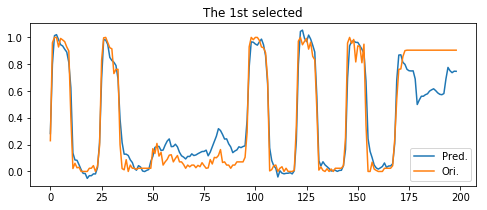

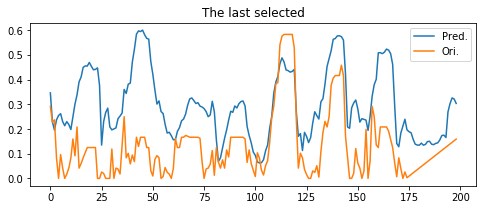

In [17]:
plt.ion()
plt.rcParams["figure.figsize"] = (8,3)
fig = plt.figure()
plt.plot(Y_pred[:,I_r2[0]], label = 'Pred.')
plt.plot(X_hour[T_tv+H:T_0,I_r2[0]], label = 'Ori.')
plt.title('The 1st selected')
plt.legend()
fig = plt.figure()
plt.plot(Y_pred[:,np.argsort(-r2)[-1]], label = 'Pred.')
plt.plot(X_hour[T_tv+H:T_0,np.argsort(-r2)[-1]], label = 'Ori.')
plt.title('The last selected')
plt.legend()

# Reconstruction performance on test set
## Construct prediction network

In [18]:
# Change some parameters for prediction network
params['dir_name']       = 'H0_reconstruct'
params['batch_size']     = 1000 
params['num_epochs']     = 20
params['M'][-1]          = P # Output dimension
params['learning_rate']  = 0.001

In [19]:
model = models.cgcnn(L, **params, selecting_mode = False)

NN architecture
  input: L_0 = 274
  layer 1: cgconv1
    representation: L_0 * F_1 / p_1 = 274 * 16 / 1 = 4384
    weights: F_0 * F_1 * K_1 = 1 * 16 * 50 = 800
    biases: L_1 * F_1 = 274 * 16 = 4384
  layer 2: fc1
    representation: L_2 = 128
    weights: L_1 * L_2 = 4384 * 128 = 561152
    biases: L_2 = 128
  layer 3: fc2
    representation: L_3 = 500
    weights: L_2 * L_3 = 128 * 500 = 64000
    biases: L_3 = 500
  layer 4: fc3
    representation: L_4 = 64
    weights: L_3 * L_4 = 500 * 64 = 32000
    biases: L_4 = 64
  layer 5: output
    representation: L_5 = 27
    weights: L_4 * L_5 = 64 * 27 = 1728
    biases: L_5 = 27
  Total number of trainable parameters: 665057
Adam optimizer is being used.


In [20]:
I = I_r2

X_train_H = np.empty((T_tv-H,     N, H+1))
X_val_H   = np.empty((T_0-T_tv-H, N, H+1))
X_test_H  = np.empty((T_1-T_0-H,  N, H+1))
for i in range(H+1):
    X_train_H[:,:,H-i] = X_hour_detrend_sc[(H-i):(T_tv-i),:]
    X_val_H[:,:,H-i]   = X_hour_detrend_sc[(T_tv+H-i):(T_0-i),:]
    X_test_H[:,:,H-i]  = X_hour_detrend_sc[(T_0+H-i):(T_1-i),:]
    
Y_train = np.copy(X_train_H[:,I,H])
X_train_H[:,I,:] = 0.0
Y_val = np.copy(X_val_H[:,I,H])
X_val_H[:,I,:] = 0.0
Y_test = np.copy(X_test_H[:,I,H])
X_test_H[:,I,:] = 0.0

In [21]:
err_mse0 = np.zeros(2)
for x in range(2):
    _, _, _, _ = model.fit(train_data = X_train_H, train_targets = Y_train, val_data = X_val_H, val_targets = Y_val)
    _,Y_pred,_,_ = model.evaluate(X_test_H, Y_test)
    # The reconstruction error on test set
    err_mse0[x] = norm(Y_test - Y_pred)**2/Y_pred.shape[0]
    print(err_mse0[x])

epoch 1 :
  training_loss = 3.63e+01
  validation r2: 0.15, loss: 1.29e+01
  time: 5s (wall 2s)
epoch 2 :
  training_loss = 2.79e+01
  validation r2: 0.44, loss: 8.47e+00
  time: 9s (wall 4s)
Instructions for updating:
Use standard file APIs to delete files with this prefix.
epoch 3 :
  training_loss = 2.37e+01
  validation r2: 0.53, loss: 7.07e+00
  time: 14s (wall 6s)
epoch 4 :
  training_loss = 2.17e+01
  validation r2: 0.50, loss: 7.53e+00
  time: 18s (wall 7s)
epoch 5 :
  training_loss = 1.99e+01
  validation r2: 0.55, loss: 6.88e+00
  time: 22s (wall 9s)
epoch 6 :
  training_loss = 1.90e+01
  validation r2: 0.56, loss: 6.55e+00
  time: 27s (wall 11s)
epoch 7 :
  training_loss = 1.81e+01
  validation r2: 0.57, loss: 6.56e+00
  time: 31s (wall 13s)
epoch 8 :
  training_loss = 1.74e+01
  validation r2: 0.57, loss: 6.44e+00
  time: 35s (wall 15s)
epoch 9 :
  training_loss = 1.65e+01
  validation r2: 0.58, loss: 6.24e+00
  time: 40s (wall 16s)
epoch 10 :
  training_loss = 1.58e+01
  v

In [22]:
err_mse0.mean()

17.86222384865575

In [23]:
# Get the predictions of the original time series
Y_pred = np.multiply(Y_pred, sd[I]) # Multiply the std back
Y_pred += wk_pf[index[T_0+H:],:][:,I] # Add the trend back

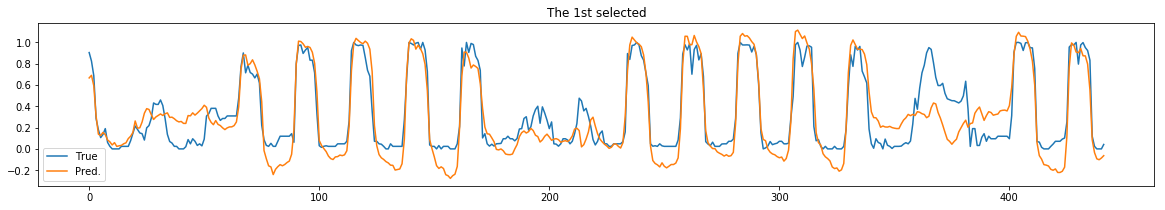

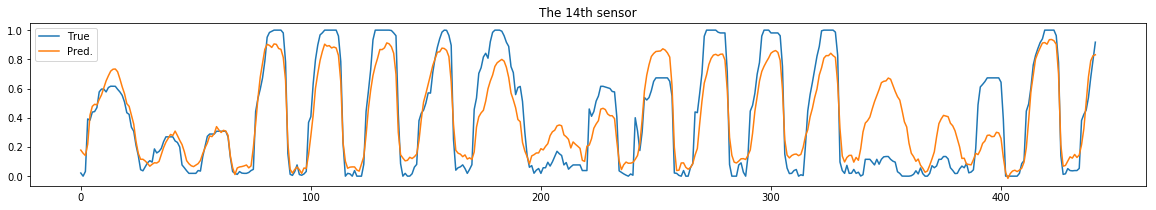

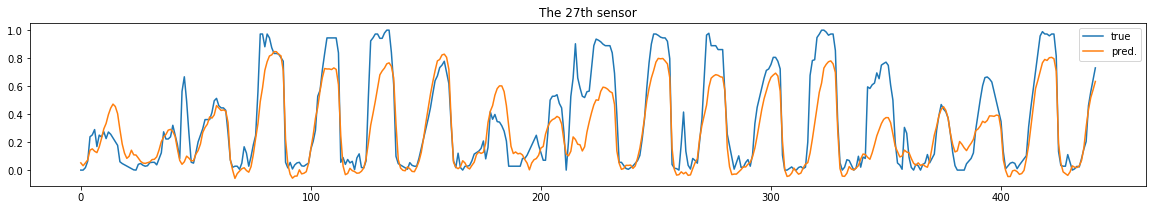

In [24]:
plt.ion()
plt.rcParams["figure.figsize"] = (20,3)
fig = plt.figure()
plt.plot(X_hour[T_0+H:,][:,I][:,0], label = 'True')
plt.plot(Y_pred[:,0], label = 'Pred.')
plt.title('The 1st selected')
plt.legend()
fig = plt.figure()
plt.plot(X_hour[T_0+H:,][:,I][:,int(P/2)], label = 'True')
plt.plot(Y_pred[:,int(P/2)], label = 'Pred.')
plt.title("The {}th sensor".format(int(P/2)+1))
plt.legend()
plt.figure()
plt.plot(X_hour[T_0+H:,][:,I][:,P-1], label = "true")
plt.plot(Y_pred[:,P-1], label = "pred.")
plt.title("The {}th sensor".format(P))
plt.legend()

# Comparison with random sampling 

In [25]:
err_mse0 = np.zeros(10)
for x in range(10):
    I_rand = np.random.choice(N, P, replace=False)
    for i in range(H+1):
        X_train_H[:,:,H-i] = X_hour_detrend_sc[(H-i):(T_tv-i),:]
        X_val_H[:,:,H-i]   = X_hour_detrend_sc[(T_tv+H-i):(T_0-i),:]
        X_test_H[:,:,H-i]  = X_hour_detrend_sc[(T_0+H-i):(T_1-i),:]
    
    Y_train = np.copy(X_train_H[:,I_rand,H])
    X_train_H[:,I_rand,:] = 0.0
    Y_val = np.copy(X_val_H[:,I_rand,H])
    X_val_H[:,I_rand,:] = 0.0
    Y_test = np.copy(X_test_H[:,I_rand,H])
    X_test_H[:,I_rand,:] = 0.0
    
    _, _, _, _ = model.fit(train_data = X_train_H, train_targets = Y_train, val_data = X_val_H, val_targets = Y_val)
    _,Y_pred,_,_ = model.evaluate(X_test_H, Y_test)
    # The reconstruction error on test set
    err_mse0[x] = norm(Y_test - Y_pred)**2/Y_pred.shape[0]
    print(err_mse0[x])

epoch 1 :
  training_loss = 3.76e+01
  validation r2: -0.23, loss: 1.30e+01
  time: 5s (wall 2s)
epoch 2 :
  training_loss = 3.35e+01
  validation r2: -0.21, loss: 1.23e+01
  time: 9s (wall 4s)
epoch 3 :
  training_loss = 3.00e+01
  validation r2: -0.15, loss: 1.15e+01
  time: 14s (wall 6s)
epoch 4 :
  training_loss = 2.76e+01
  validation r2: -0.16, loss: 1.13e+01
  time: 18s (wall 8s)
epoch 5 :
  training_loss = 2.49e+01
  validation r2: -0.14, loss: 1.10e+01
  time: 23s (wall 9s)
epoch 6 :
  training_loss = 2.31e+01
  validation r2: -0.11, loss: 1.09e+01
  time: 27s (wall 11s)
epoch 7 :
  training_loss = 2.15e+01
  validation r2: -0.19, loss: 1.12e+01
  time: 32s (wall 13s)
epoch 8 :
  training_loss = 2.00e+01
  validation r2: -0.21, loss: 1.13e+01
  time: 36s (wall 15s)
 Training stopped for the validation loss starts to increase.
validation score: peak = -0.11, mean = -0.16
validation loss: min = 10.93, mean = 11.15
INFO:tensorflow:Restoring parameters from /Users/yiye/Desktop/vel

27.490425467963494
epoch 1 :
  training_loss = 3.79e+01
  validation r2: -0.27, loss: 1.35e+01
  time: 5s (wall 2s)
epoch 2 :
  training_loss = 3.33e+01
  validation r2: -0.13, loss: 1.18e+01
  time: 9s (wall 4s)
epoch 3 :
  training_loss = 2.90e+01
  validation r2: -0.01, loss: 1.06e+01
  time: 14s (wall 6s)
epoch 4 :
  training_loss = 2.62e+01
  validation r2: -0.09, loss: 1.12e+01
  time: 18s (wall 7s)
epoch 5 :
  training_loss = 2.43e+01
  validation r2: -0.06, loss: 1.10e+01
  time: 22s (wall 9s)
epoch 6 :
  training_loss = 2.22e+01
  validation r2: -0.04, loss: 1.08e+01
  time: 27s (wall 11s)
epoch 7 :
  training_loss = 2.08e+01
  validation r2: -0.04, loss: 1.06e+01
  time: 31s (wall 13s)
epoch 8 :
  training_loss = 1.95e+01
  validation r2: -0.05, loss: 1.06e+01
  time: 36s (wall 15s)
epoch 9 :
  training_loss = 1.82e+01
  validation r2: -0.05, loss: 1.07e+01
  time: 40s (wall 16s)
epoch 10 :
  training_loss = 1.73e+01
  validation r2: -0.03, loss: 1.06e+01
  time: 44s (wall 18

In [26]:
err_mse0.mean()

29.002288521478466